<a href="https://colab.research.google.com/github/FKz11/Portfolio_Data_Science_2.0/blob/main/Time_Series/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series

## Задача анализа временного ряда

### Задача:

Обучить модель предсказывать количество пассажиров по месяцам

### Библиотеки:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError

### Данные:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.shape

(144, 2)

### Сортируем по дате

In [ ]:
data_time = df.sort_values(by=['Month'], ascending=True)
data_time.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132


### График

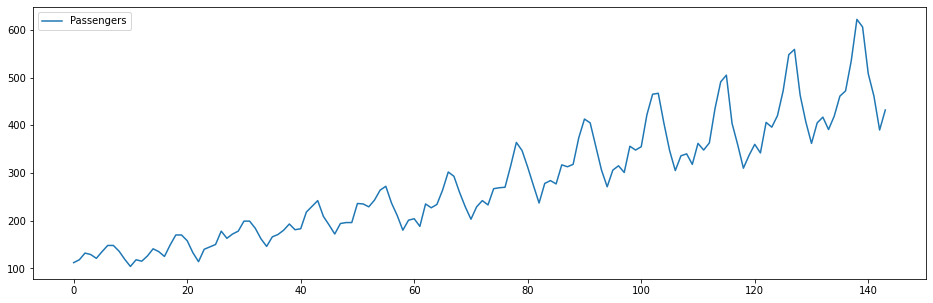

In [ ]:
data_time.plot( figsize = (16,5))

### Статистика

In [ ]:
data_time.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### Преобразование данных

In [ ]:
data_time['Year'] = data_time['Month'].apply(lambda x: float(x[:4]))
data_time['Month'] = data_time['Month'].apply(lambda x: float(x[5:]))
data_time.head()

,Month,Passengers,Year
0,1.0,112,1949.0
1,2.0,118,1949.0
2,3.0,132,1949.0


In [ ]:
data_time.shape

(144, 3)

### Рекурентная нейронная сеть

In [ ]:
def nn(df, length_series=6, size_test=0.33, hidden_neurons=100, add_neurons=100, 
                batch_size=32, epochs=100, verbose=1, seed=42, plot=False):

  np.random.seed(seed)

  data_time = df.copy() # скопируем, чтобы манипуляции не влияли на оригинал

  length_data = len(data_time) # количество данных = 144

  split_point = int((length_data-length_series)*(1-size_test)) # точка разделения train/test = 92

  # нормализация данных
  scaler = StandardScaler()
  data_time.loc[:split_point+length_series-1, 'Year'] = scaler.fit_transform(data_time.loc[:split_point+length_series-1, 'Year'].values.reshape(-1, 1))
  data_time.loc[split_point+length_series:, 'Year'] = scaler.transform(data_time.loc[split_point+length_series:, 'Year'].values.reshape(-1, 1))
  data_time.loc[:split_point+length_series-1, 'Month'] = scaler.fit_transform(data_time.loc[:split_point+length_series-1, 'Month'].values.reshape(-1, 1))
  data_time.loc[split_point+length_series:, 'Month'] = scaler.transform(data_time.loc[split_point+length_series:, 'Month'].values.reshape(-1, 1))
  data_time.loc[:split_point+length_series-1, 'Passengers'] = scaler.fit_transform(data_time.loc[:split_point+length_series-1, 'Passengers'].values.reshape(-1, 1))
  data_time.loc[split_point+length_series:, 'Passengers'] = scaler.transform(data_time.loc[split_point+length_series:, 'Passengers'].values.reshape(-1, 1))
  # последний scaler отвечает за 'Passengers'

  # data_time split
  X_train, y_train, X_test, y_test = [], [], [], []

  for i in range(length_data - length_series):
    X = data_time[i:length_series+i].values
    y = data_time[i+1:length_series+i+1].iloc[:,1].values
    if i < split_point:
      X_train.append(X)
      y_train.append(y)
    else:
      X_test.append(X)
      y_test.append(y)

  # create model
  model = Sequential()
  model.add(LSTM(hidden_neurons, return_sequences=True,
        input_shape=(length_series, data_time.shape[1])))
  model.add(Dense(add_neurons))
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam",
              metrics=[RootMeanSquaredError()])
  model.fit(np.array(X_train), np.array(y_train), batch_size=batch_size,
          epochs=epochs, verbose=verbose, shuffle=False,
          validation_data=(np.array(X_test), np.array(y_test)))
  
  # преобразуем наши данные обратно
  y_train_orig = scaler.inverse_transform(list(map(lambda x: [x[-1]], y_train)))
  y_test_orig = scaler.inverse_transform(list(map(lambda x: [x[-1]], y_test)))
  pred_train = scaler.inverse_transform( list(map(lambda x: x[-1], model.predict(np.array(X_train)))))
  pred_test = scaler.inverse_transform( list(map(lambda x: x[-1], model.predict(np.array(X_test)))))

  #график
  if plot:
    plt.figure(figsize=(16, 5))
    plt.plot(np.append(y_train_orig, y_test_orig), color='green')
    plt.plot(pred_train, color='orange')
    plt.plot(np.append([None]*len(pred_train), pred_test), color='red')
    plt.show()

  return (np.sqrt(mean_squared_error(y_train_orig, pred_train)), 
         np.sqrt(mean_squared_error(y_test_orig, pred_test)))

В моей нейронной сети return_sequences=True, то есть я хочу, чтобы каждый нейрон кроме того, чтобы помогать предсказывать следующее число пассажиров после приходящей на вход истории векторов, где каждый вектор состоит из (месяц, число пассажиров, год), ещё и предсказывал следующее число пассажиров после той истории векторов, которую он уже видел. Так я хочу помочь моей нейронной сети "думать" в правильно направлении в условии малых данных (144).

Epoch 1/100
3/3 [==============================] - 3s 225ms/step - loss: 0.8965 - root_mean_squared_error: 0.9468 - val_loss: 6.1050 - val_root_mean_squared_error: 2.4708
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 0.5586 - root_mean_squared_error: 0.7474 - val_loss: 4.0938 - val_root_mean_squared_error: 2.0233
Epoch 3/100
3/3 [==============================] - 0s 25ms/step - loss: 0.3456 - root_mean_squared_error: 0.5879 - val_loss: 2.6183 - val_root_mean_squared_error: 1.6181
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952 - val_loss: 1.7851 - val_root_mean_squared_error: 1.3361
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 0.2423 - root_mean_squared_error: 0.4922 - val_loss: 1.4860 - val_root_mean_squared_error: 1.2190
Epoch 6/100
3/3 [==============================] - 0s 25ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073 - val_loss: 1.3725 - val_root_mean_s

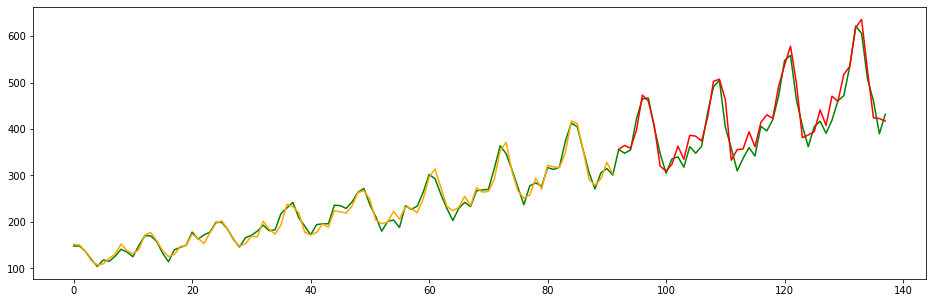

rmse_train = 10.365556644276431, rmse_test = 24.59149184777786


In [ ]:
rmse_train, rmse_test = nn(data_time, length_series=6, size_test=0.33, 
              hidden_neurons=100, add_neurons=100, batch_size=32, epochs=100, 
                      verbose=1, seed=42, plot=True)
print(f'rmse_train = {rmse_train}, rmse_test = {rmse_test}')

Вертикальная ось - количество пассажиров. Горизонтальная ось - номер месяца. Зелёная линия - оригинальные данные. Оранжевая линия - предсказания модели на тренировочной выборке. Красная линия - предсказания модели на тестовой выборке.

### length_series

In [ ]:
%%time

length_series_list = list(range(2, 13))

metrics_length_series = []

for length_series in length_series_list:
  metric = nn(data_time, length_series=length_series, size_test=0.33, 
                hidden_neurons=100, add_neurons=100, batch_size=32, epochs=100, 
                        verbose=0, seed=42, plot=False)[1]
  print(f'{length_series} - {metric}')
  metrics_length_series.append(metric)

2 - 35.646366848935045
3 - 43.4783049471508
4 - 40.82008654990133
5 - 28.456079599613435
6 - 27.044521284352378
7 - 29.177146638265384
8 - 32.47455776156385
9 - 34.814362146034846
10 - 31.70018126250804
11 - 31.12956653541219
12 - 28.6527609571879
CPU times: user 2min 31s, sys: 4.08 s, total: 2min 35s
Wall time: 2min 15s


No handles with labels found to put in legend.


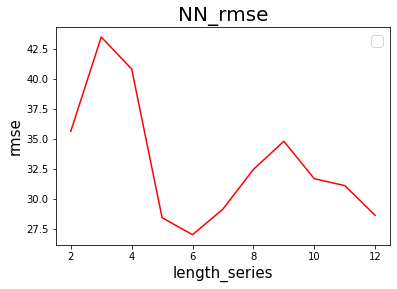

In [ ]:
plt.plot(length_series_list, metrics_length_series, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('length_series', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

График получился инетерсным, сложно обозначить явные закономерности, но нейронная сеть лучше обучается, когда подаётся история длинной в районе полу года или года. Так же плохо обучается, когда длина истории маленькая. Лучшие результаты, когда length_series = 6.

### hidden_neurons

In [ ]:
%%time

hidden_neurons_list = [10, 20, 30, 50, 100, 200, 300, 500, 1000]

metrics_hidden_neurons = []

for hidden_neurons in hidden_neurons_list:
  metric = nn(data_time, length_series=6, size_test=0.33, 
      hidden_neurons=hidden_neurons, add_neurons=100, batch_size=32, epochs=100, 
                verbose=0, seed=42, plot=False)[1]
  print(f'{hidden_neurons} - {metric}')
  metrics_hidden_neurons.append(metric)

10 - 40.727162753076655
20 - 26.328653461637533
30 - 24.33183514998351
50 - 26.187993929384486
100 - 27.4360791947656
200 - 27.064677693053547
300 - 33.178474090647065
500 - 40.14373639140404
1000 - 36.54986097623455
CPU times: user 8min 21s, sys: 19.6 s, total: 8min 41s
Wall time: 6min


No handles with labels found to put in legend.


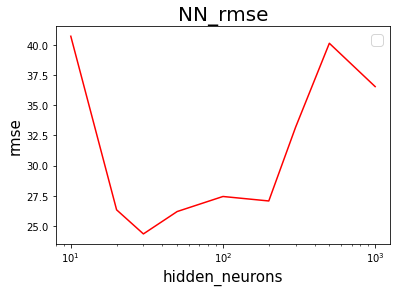

In [ ]:
plt.plot(hidden_neurons_list, metrics_hidden_neurons, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('hidden_neurons', fontsize=15)
plt.xscale('log')
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

График получился хорошим. Видно, что при маленьком количестве нейронов lstm слоя нейронная сеть недообучается, при большом количестве, переобучается. Лучшая метрика при hidden_neurons = 30.

### add_neurons

In [ ]:
%%time

add_neurons_list = [10, 20, 30, 50, 100, 200, 300, 500, 1000]

metrics_add_neurons = []

for add_neurons in add_neurons_list:
  metric = nn(data_time, length_series=6, size_test=0.33, 
      hidden_neurons=100, add_neurons=add_neurons, batch_size=32, epochs=100, 
                verbose=0, seed=42, plot=False)[1]
  print(f'{add_neurons} - {metric}')
  metrics_add_neurons.append(metric)

10 - 29.230332593942695
20 - 29.747770108759457
30 - 31.669454334251533
50 - 25.146512469335807
100 - 24.047707733835015
200 - 30.022074958513166
300 - 32.19511099099623
500 - 26.855735930502043
1000 - 39.81773522411614
CPU times: user 2min 2s, sys: 3.17 s, total: 2min 5s
Wall time: 2min 3s


No handles with labels found to put in legend.


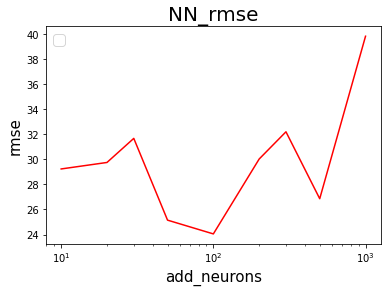

In [ ]:
plt.plot(add_neurons_list, metrics_add_neurons, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('add_neurons', fontsize=15)
plt.xscale('log')
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

По графику видно, что так же как и hidden_neurons, при мальком количетсве add_neurons нейронная сеть недообучается, а при большом, переобучается. Лучшая метрика при add_neurons = 100.

### batch_size

In [ ]:
%%time

batch_size_list = [1, 2, 3, 5, 10, 20, 30, 50, 100]

metrics_batch_size = []

for batch_size in batch_size_list:
  metric = nn(data_time, length_series=6, size_test=0.33, 
      hidden_neurons=100, add_neurons=100, batch_size=batch_size, epochs=100, 
                verbose=0, seed=42, plot=False)[1]
  print(f'{batch_size} - {metric}')
  metrics_batch_size.append(metric)

1 - 47.22267524299997
2 - 32.43095261773827
3 - 34.28073794643196
5 - 23.394173386878848
10 - 27.688641592768946
20 - 24.40287750755791
30 - 26.08396451774684
50 - 27.05058761982454
100 - 24.792889192337984
CPU times: user 6min 13s, sys: 11.4 s, total: 6min 25s
Wall time: 5min 24s


No handles with labels found to put in legend.


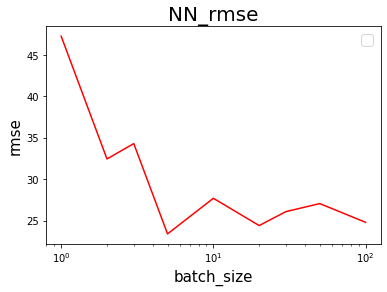

In [ ]:
plt.plot(batch_size_list, metrics_batch_size, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('batch_size', fontsize=15)
plt.xscale('log')
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Видно, что при batch_size = 1 (стохастический градиентный спуск) нейронная сеть обучается долга и переобучается. При batch_size >= 5, нейронная сеть обучается быстро и не переобучается, выдавая лучшую метрику. При batch_size > 92 метрика будет такой же, как и при batch_size = 92, так как у нас всего в тренировочном наборе данных 92 экземпляра и это будет обычный градиентный спуск. Лучшая метрика при batch_size = 5.

### epochs

Так как я стандартизировал данные и обучаю свою модель при return_sequences=True, то та метрика, которая сохраняется в истории обучания нейронной сети плохо читабильная и даже не совсем коректная к поставленной задачи. Поэтому мне придётся переобучать нейронную сеть с разным количеством эпох и смотреть на конечные метрики.

In [ ]:
%%time

epochs_list = [10, 20, 30, 50, 100, 200, 300, 500, 1000]

metrics_epochs = []

for epochs in epochs_list:
  metric = nn(data_time, length_series=6, size_test=0.33, 
      hidden_neurons=100, add_neurons=100, batch_size=32, epochs=epochs, 
                verbose=0, seed=42, plot=False)[1]
  print(f'{epochs} - {metric}')
  metrics_epochs.append(metric)

10 - 49.83713353549406
20 - 50.14677519088906
30 - 37.02754474299101
50 - 25.251286069431046
100 - 24.992783020739004
200 - 54.82601706193829
300 - 36.74356957525621
500 - 21.478849952911258
1000 - 32.56911638475402
CPU times: user 3min 53s, sys: 6.29 s, total: 4min
Wall time: 3min 33s


No handles with labels found to put in legend.


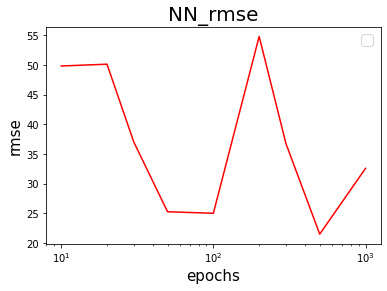

In [ ]:
plt.plot(epochs_list, metrics_epochs, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('epochs', fontsize=15)
plt.xscale('log')
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

Видно, что при маленьком количестве эпох, нейронная сеть недообучается. Далее нейронная сеть достигает локального минмума после epochs = 100 и начинает расходится ища новый минимум, находя его рядом с epochs = 500 и далее опять расходится. За это поведение отвечает используемый оптимизатор градиентного спуска 'adam'.

### seed

Так же посмотрим, насколько устойчива нейронная сеть, как сильно на неё влияют случайные начальные веса.

In [ ]:
%%time

seed_list = list(range(10))

metrics_seed = []

for seed in seed_list:
  metric = nn(data_time, length_series=6, size_test=0.33, 
      hidden_neurons=100, add_neurons=100, batch_size=32, epochs=100, 
                verbose=0, seed=seed, plot=False)[1]
  print(f'{seed} - {metric}')
  metrics_seed.append(metric)

0 - 24.97364577598938
1 - 27.48700982205085
2 - 29.666810725324634
3 - 25.864733941331252
4 - 30.473949553516796
5 - 29.2678988378376
6 - 30.986230478936214
7 - 31.43505380631302
8 - 29.01571091073962
9 - 27.323927456159772
CPU times: user 2min 11s, sys: 3.12 s, total: 2min 14s
Wall time: 2min 19s


No handles with labels found to put in legend.


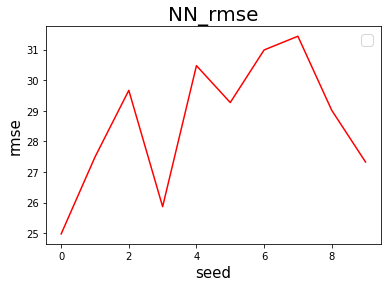

In [ ]:
plt.plot(seed_list, metrics_seed, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('seed', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

In [ ]:
np.std(metrics_seed)

2.060947268574463

Видно, что нейронная сеть довольна устойчивая, метрики разбросаны не сильно и нет случая, когда нейронная сеть разошлась.

### random

Посмотрим, как разбросаны метрики при фиксированном seed, унаем насколько влияет фиксация seed сравнивая результаты с прошлым пунктом.

In [ ]:
%%time

random_list = list(range(10))

metrics_random = []

for random in random_list:
  metric = nn(data_time, length_series=6, size_test=0.33, 
      hidden_neurons=100, add_neurons=100, batch_size=32, epochs=100, 
                verbose=0, seed=42, plot=False)[1]
  print(f'{random} - {metric}')
  metrics_random.append(metric)

0 - 24.670551878055615
1 - 24.244238285687345
2 - 30.92962794106379
3 - 28.380152656775024
4 - 25.864125864953113
5 - 28.690355575691566
6 - 26.063160055380237
7 - 26.47277569735256
8 - 29.849913335755932
9 - 29.252253632976373
CPU times: user 2min 10s, sys: 3.27 s, total: 2min 13s
Wall time: 2min


No handles with labels found to put in legend.


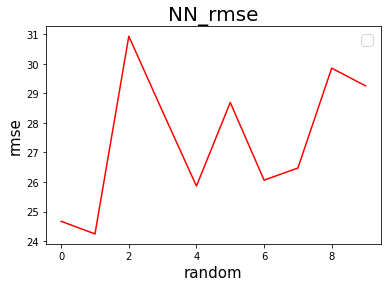

In [ ]:
plt.plot(random_list, metrics_random, color = 'red')
plt.title('NN_rmse', fontsize=20)
plt.xlabel('random', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

In [ ]:
np.std(metrics_random)

2.1659644860144147

Видно, что фиксация seed не влияет на разброс метрик.

### Вывод:

Я решил задачу анализа временного ряда. Я довольно точно обучил модель предсказывать количество пассажиров по месяцам использую рекурентную нейронную сеть на основе LSTM слоя с return_sequences=True. А так же верно разбил данные для моего решения. Я поэксперементировал с выведенноми мною гиперпараметрами рекурентной нейронной сети и описал каждый эксперимент.